THINGS TO CHECK
- check rescale
- load on demand vs load on init

In [1]:
import sys
sys.path.append('../src')

import albumentations as A
import random
import numpy as np
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation, OneFormerConfig
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from transformers.models.oneformer.image_processing_oneformer import load_metadata, prepare_metadata
from safetensors.torch import load_model, save_model
from config import DATASET_DIR, CLASS_INFO_PATH, MAIN_PROJECT_DIR, GALAXY_MEAN, GALAXY_STD
from visual import *
from dataset import *
from utils import *

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.15 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [2]:
torch.cuda.is_available()

True

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [5]:
id2label, label2id = get_id2label_mappings()

config = OneFormerConfig.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny", 
                                         num_classes = len(id2label),
                                         id2label = id2label,
                                         label2id = label2id,
                                         is_training=True)


/home/panzaresce/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# model_card = "shi-labs/oneformer_coco_dinat_large"
model_card = "shi-labs/oneformer_ade20k_swin_tiny"
model = OneFormerForUniversalSegmentation.from_pretrained(model_card, config=config, ignore_mismatched_sizes=True)
processor = OneFormerProcessor.from_pretrained(model_card)

Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

In [7]:
# Uncomment to load from fine-tuned model
# load_model(model, "../safetensors/model.safetensors")

In [7]:
# Metadata must be set according to the dataset through the class_info.json file. Background class must be specified as well. 
processor.image_processor.repo_path = MAIN_PROJECT_DIR
processor.image_processor.class_info_file = os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)
processor.image_processor.metadata = prepare_metadata(load_metadata(MAIN_PROJECT_DIR, os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)))
processor.image_processor.num_text = model.config.num_queries - model.config.text_encoder_n_ctx
processor.image_processor.do_resize = False
processor.image_processor.do_rescale = False

In [9]:
MAIN_PROJECT_DIR

'/home/panzaresce/repos/galaxy_segmentation'

In [8]:
# Augmentations
transform = A.Compose([
    A.OneOf([
        A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.OneOf([
                A.Rotate(limit=(90), p=1),
                A.Rotate(limit=(180), p=1),
                A.Rotate(limit=(270), p=1)
            ], p=1)
        ]),
        A.NoOp()
    ], p=1.0)
])

In [10]:
dataset_train = GalaxyDataset(DATASET_DIR, "train", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD, load_on_demand=True)

In [11]:
dataset_val = GalaxyDataset(DATASET_DIR, "val", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD, load_on_demand=True)

In [12]:
dataset_test = GalaxyDataset(DATASET_DIR, "test", processor, CLASS_INFO_PATH, None, GALAXY_MEAN, GALAXY_STD, load_on_demand=True)

In [9]:
dataset_abl = GalaxyDataset(DATASET_DIR, "test", processor, CLASS_INFO_PATH, None, GALAXY_MEAN, GALAXY_STD, load_on_demand=True, subset_idx=1000)

In [9]:
dataset_abl_trans = GalaxyDataset(DATASET_DIR, "test", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD, load_on_demand=True, subset_idx=1000)

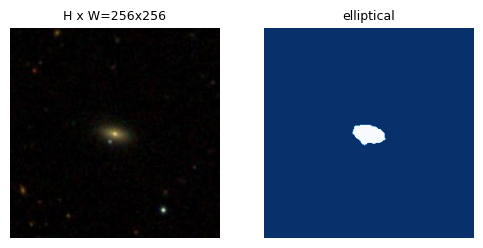

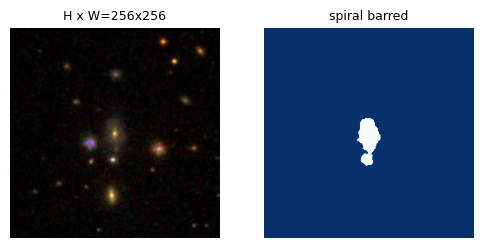

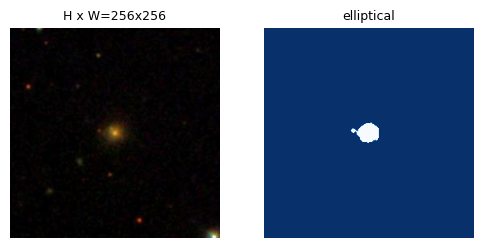

In [27]:
display_n_samples(dataset_train, 3)

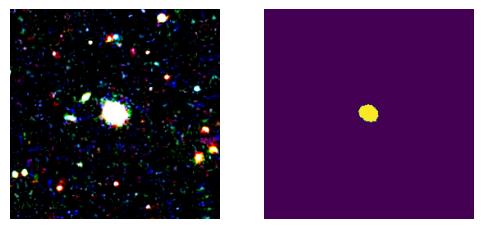

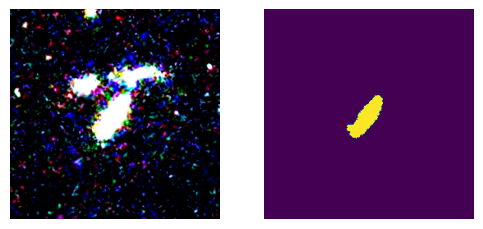

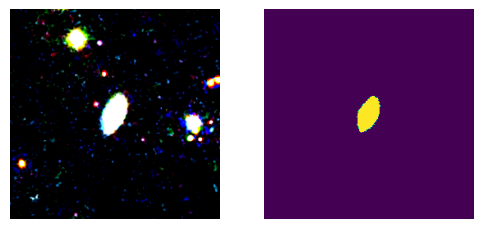

In [15]:
display_n_samples(dataset_train, 3, False)

In [16]:
batch_size = 1
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

#### Preliminary test on hyperparamters (grid search)

First round of grid search, the following hyperparameters are tested:
- learning rate: [1e-3, 1e-4]
- weight decay: [0.01, 0.05, 0.1]
- scheduler: [None, polynomial, warmup+poly, decay fixed, warmup+decay fixed]
    - The "decay fixed" reduce the lr by a factor of 10 at 90% and 95% of total steps

In [12]:
grid_dict = {
    0: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.01,
            "lr_d": None
        }
    },
    1: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": None
        }
    },
    2: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-3,
            "wd": 0.05,
            "lr_d": None
        }
    },
    3: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": None
        }
    },
    4: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "poly"
        }
    },
    5: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "poly"
        }
    },
    6: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "fixed"
        }
    },
    7: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "fixed"
        }
    },
    8: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "warm"
        }
    },
    9: {
        "loss": list(),
        "miou": 0,
        "acc": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "warm"
        }
    },
    10: {
        "loss": list(),
        "miou": 0,
        "acc": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "warm_fixed"
        }
    },
    11: {
        "loss": list(),
        "miou": 0,
        "acc": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "warm_fixed"
        }
    }
}

In [11]:
overfit_loader = DataLoader(dataset_abl, batch_size=1, shuffle=False)

In [ ]:
model = OneFormerForUniversalSegmentation.from_pretrained(model_card, config=config, ignore_mismatched_sizes=True)
    
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.1)
model.train()
model.model.is_training = True
model.to(device)

sched = WarmupPolyLR(optimizer, len(dataset_abl), warmup_iters=10, warmup_factor=1.0)

print("Training")
for batch_idx, batch in enumerate(overfit_loader):
    # plt.imshow(batch["pixel_values"].squeeze().permute(1,2,0))
    optimizer.zero_grad()

    batch = {k:v.to(device) for k,v in batch.items()}
    outputs = model(**batch)  
    
    outputs.loss.backward()
    norm = clip_grad_norm_(model.parameters(), 0.01)
    optimizer.step()
    sched.step()

    all_grads = []
    for param in model.parameters():
        if param.grad is not None:
            all_grads.append(param.grad.view(-1))  # Flatten the gradient tensor

    # Concatenate all gradients into a single tensor
    all_grads = torch.cat(all_grads)

    # Compute global min and max gradients
    global_grad_min = all_grads.min().item()
    global_grad_max = all_grads.max().item()
    # print(f"loss: {outputs.loss.item():.4f} | norm: {norm:.4f} | grad min: {global_grad_min:.4f} | grad max: {global_grad_max:.4f}")

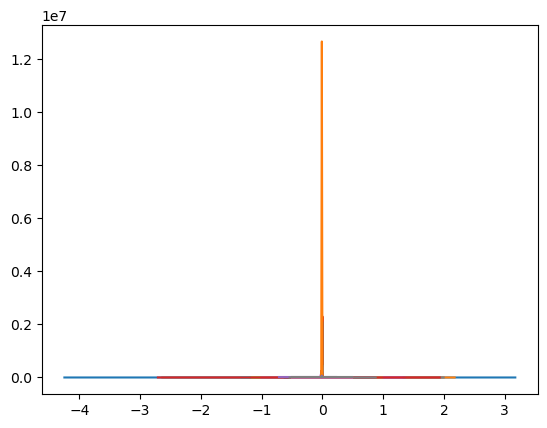

In [60]:
legends = []
max_grad = 0
max_grad_name = ""
for i, p in enumerate(model.named_parameters()):
    g = p[1].grad.view(-1)
    if g.detach().max().item() > max_grad:
        max_grad = g.detach().max().item()
        max_grad_name = p[0]
    y, x = torch.histogram(g.cpu())
    plt.plot(x[:-1].detach(), y.detach())
    legends.append(f"l: {p[0]}")
# plt.legend(legends)

In [20]:
def train_for_grid_search(dataset, dict_value, grad_clip = False):
    model = OneFormerForUniversalSegmentation.from_pretrained(model_card, config=config, ignore_mismatched_sizes=True)
    
    optimizer = AdamW(model.parameters(), lr=dict_value["param"]["lr"], weight_decay=dict_value["param"]["wd"])
    model.train()
    model.model.is_training = True
    model.to(device)
    
    scheduler_list = list()

    if dict_value["param"]["lr_d"] == "poly":
        scheduler_list.append(WarmupPolyLR(optimizer, len(dataset), warmup_iters=0))
    if dict_value["param"]["lr_d"] == "warm":
        scheduler_list.append(WarmupPolyLR(optimizer, len(dataset), warmup_iters=10, warmup_factor=1.0))
    if dict_value["param"]["lr_d"] == "fixed":
        scheduler_list.append(torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[900,950], gamma=0.1))
    if dict_value["param"]["lr_d"] == "warm_fixed":
        scheduler_list.append(WarmupPolyLR(optimizer, len(dataset), warmup_iters=10, warmup_factor=1.0))
        scheduler_list.append(torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[900,950], gamma=0.1))

    overfit_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    print("Training")
    for batch_idx, batch in enumerate(overfit_loader):
        # plt.imshow(batch["pixel_values"].squeeze().permute(1,2,0))
        optimizer.zero_grad()

        batch = {k:v.to(device) for k,v in batch.items()}
        outputs = model(**batch)  
        
        dict_value["loss"].append(outputs.loss.item())

        outputs.loss.backward()
        if grad_clip:
            clip_grad_norm_(model.parameters(), dict_value["param"]["clip"])
        optimizer.step()

        if dict_value["param"]["lr_d"] != None:
            for sched in scheduler_list:
                sched.step()
    
    print("Evaluation")
    miou, dice = compute_metrics(dataset, model, processor)
    dict_value["miou"] = miou/len(dataset)
    dict_value["dice"] = dice/len(dataset)

In [48]:
vector_size = 68242306
random_vector = np.random.uniform(0, 0.001, int(vector_size))

euclidean_norm = np.linalg.norm(random_vector)
print(f"{euclidean_norm=:.4f}")

euclidean_norm=4.7691


In [ ]:
for k,v in grid_dict.items():
    print(f"Processing conf n. {k}")
    train_for_grid_search(overfit_loader, v)

0: {'miou': tensor(0.3782), 'dice': tensor(0.4047), 'param': {'lr': 0.0001, 'wd': 0.01, 'lr_d': None}}
1: {'miou': tensor(0.3720), 'dice': tensor(0.4015), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': None}}
2: {'miou': tensor(0.3526), 'dice': tensor(0.3884), 'param': {'lr': 0.001, 'wd': 0.05, 'lr_d': None}}
3: {'miou': tensor(0.3727), 'dice': tensor(0.4039), 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': None}}
4: {'miou': tensor(0.4005), 'dice': tensor(0.4317), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'poly'}}
5: {'miou': tensor(0.4097), 'dice': tensor(0.4401), 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'poly'}}
6: {'miou': tensor(0.3749), 'dice': tensor(0.4058), 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'fixed'}}
7: {'miou': tensor(0.2441), 'dice': tensor(0.2608), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'fixed'}}
8: {'miou': tensor(0.3803), 'dice': tensor(0.4060), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'warm'}}
9: {'miou': tensor(0.4316), 'acc': 0, 'param': {'lr': 0.0001, 'wd

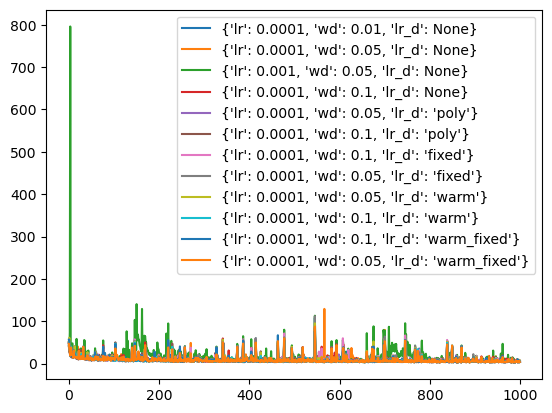

In [20]:
for k,v in grid_dict.items():
    plt.plot(v["loss"], label=v["param"])
    plt.legend()
    val = {a: b for a,b in v.items() if a != "loss" }
    print(f"{k}: {val}")

Second round of grid search, trying augmentation and gradient clipping on best configurations from step 1

In [13]:
# 4,5,9,11 from previous step
grid_dict_2 =  {
    0: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "poly",
            "clip": 1.0,
        }
    },
    1: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "poly",
            "clip": 1.0,
        }
    },
    2: {
        "loss": list(),
        "miou": 0,
        "acc": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "warm",
            "clip": 1.0,
        }
    },
    3: {
        "loss": list(),
        "miou": 0,
        "acc": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "warm_fixed",
            "clip": 1.0,
        }
    },
    4: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "poly",
            "clip": 0.01,
        }
    },
    5: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "poly",
            "clip": 0.01,
        }
    },
    6: {
        "loss": list(),
        "miou": 0,
        "acc": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "warm",
            "clip": 0.01,
        }
    },
    7: {
        "loss": list(),
        "miou": 0,
        "acc": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "warm_fixed",
            "clip": 0.01,
        }
    }
}

In [14]:
for k,v in grid_dict_2.items():
    print(f"Processing conf n. {k}")
    train_for_grid_search(overfit_loader, v, True)

Processing conf n. 0


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training


/home/panzaresce/anaconda3/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Evaluation
Processing conf n. 1


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 2


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 3


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 4


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 5


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 6


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 7


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation


0: {'miou': tensor(0.4292), 'dice': tensor(0.4598), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'poly', 'clip': 1.0}}
1: {'miou': tensor(0.4435), 'dice': tensor(0.4741), 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'poly', 'clip': 1.0}}
2: {'miou': tensor(0.4405), 'acc': 0, 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'warm', 'clip': 1.0}, 'dice': tensor(0.4717)}
3: {'miou': tensor(0.4105), 'acc': 0, 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'warm_fixed', 'clip': 1.0}, 'dice': tensor(0.4427)}
4: {'miou': tensor(0.4345), 'dice': tensor(0.4639), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'poly', 'clip': 0.01}}
5: {'miou': tensor(0.3836), 'dice': tensor(0.4125), 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'poly', 'clip': 0.01}}
6: {'miou': tensor(0.4291), 'acc': 0, 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'warm', 'clip': 0.01}, 'dice': tensor(0.4601)}
7: {'miou': tensor(0.4316), 'acc': 0, 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'warm_fixed', 'clip': 0.01}, 'dice': tensor(0.4612)}


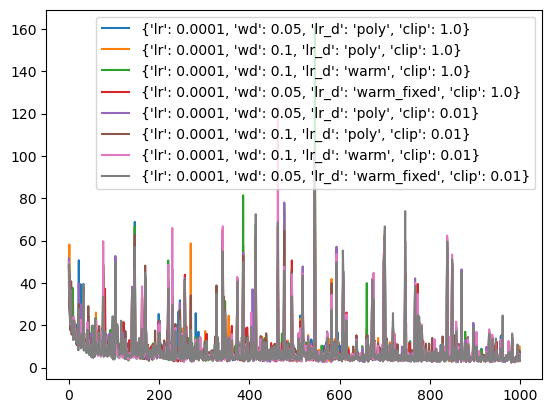

In [16]:
for k,v in grid_dict_2.items():
    plt.plot(v["loss"], label=v["param"])
    plt.legend()
    val = {a: b for a,b in v.items() if a != "loss" }
    print(f"{k}: {val}")

Third round of grid search, add augmentation

In [21]:
# 1,4,6,7 from previous step
grid_dict_3 =  {
    0: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "poly",
            "clip": 1.0,
        }
    },
    1: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "poly",
            "clip": 0.01,
        }
    },
    2: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.1,
            "lr_d": "warm",
            "clip": 0.01,
        }
    },
    3: {
        "loss": list(),
        "miou": 0,
        "dice": 0,
        "param": {
            "lr": 1e-4,
            "wd": 0.05,
            "lr_d": "warm_fixed",
            "clip": 0.01,
        }
    }
}

In [22]:
for k,v in grid_dict_3.items():
    print(f"Processing conf n. {k}")
    train_for_grid_search(dataset_abl_trans, v, True)

Processing conf n. 0


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 1


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 2


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation
Processing conf n. 3


Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_ade20k_swin_tiny and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

Training
Evaluation


0: {'miou': tensor(0.3816), 'dice': tensor(0.4074), 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'poly', 'clip': 1.0}}
1: {'miou': tensor(0.4042), 'dice': tensor(0.4400), 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'poly', 'clip': 0.01}}
2: {'miou': tensor(0.4293), 'acc': 0, 'param': {'lr': 0.0001, 'wd': 0.1, 'lr_d': 'warm', 'clip': 0.01}, 'dice': tensor(0.4590)}
3: {'miou': tensor(0.4245), 'acc': 0, 'param': {'lr': 0.0001, 'wd': 0.05, 'lr_d': 'warm_fixed', 'clip': 0.01}, 'dice': tensor(0.4529)}


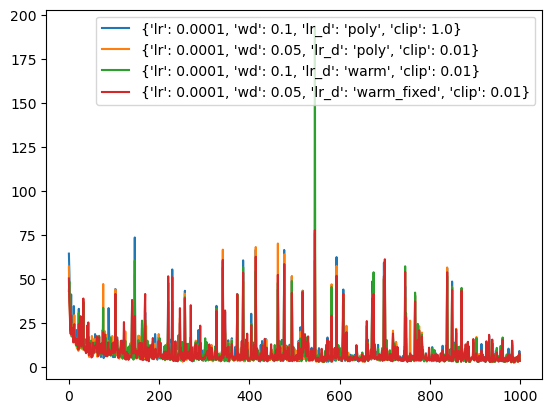

In [23]:
for k,v in grid_dict_3.items():
    plt.plot(v["loss"], label=v["param"])
    plt.legend()
    val = {a: b for a,b in v.items() if a != "loss" }
    print(f"{k}: {val}")

In [63]:
n_epochs = 2
starting_epoch = 0
verbose = True

lr_schedule = [5e-5, 5e-6]

tr_loss = []
val_loss = []

training_steps = 0
model.to(device)
for epoch in range(starting_epoch, n_epochs):
  print(f"Epoch {epoch+1}, lr = {lr_schedule[epoch]}")
  optimizer = AdamW(model.parameters(), lr=lr_schedule[epoch])
  model.train()
  model.model.is_training = True

  tr_running_loss = 0.0

  for batch_idx, batch in enumerate(train_dataloader):
    training_steps += 1
    
    optimizer.zero_grad()

    batch = {k:v.to(device) for k,v in batch.items()}
    outputs = model(**batch)

    print(batch.keys())
    tr_running_loss += outputs.loss.item()
    
    avg_loss = tr_running_loss / (batch_idx + 1)
    tr_loss.append(avg_loss)
    
    # print every 5% of progress
    if verbose or (batch_idx + 1) % (len(train_dataloader) // 20) == 0 or batch_idx < 10 :
      print(f"Avg loss at iteration n. {(batch_idx + 1)} / {len(train_dataloader)}: {avg_loss}")

    outputs.loss.backward()
    optimizer.step()
  
  # Validation loop
  model.eval()
  val_running_loss = 0.0
  print("Validation loop")
  for batch_idx, batch in enumerate(val_dataloader):
    batch = {k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)
    val_running_loss += outputs.loss.item()
  
  val_loss.append(val_running_loss / len(val_dataloader) * batch_size)
  print(f"Validation loss at epoch {epoch}: {val_loss[-1]}")


Epoch 1, lr = 5e-05


KeyError: 4

In [18]:
with open("tr_loss.blob", 'w') as fp:
    for val in tr_loss:
        # write each item on a new line
        fp.write("%s\n" % val)
    print('Done')

Done


In [34]:
running_iou = compute_miou(dataset_test, model)
print(f"mIoU: {running_iou / len(dataset_test)}")

mIoU: 0.009194090962409973
